In [1]:
#5.3.1 Feature Extraction
import tensorflow as tf
from tensorflow.keras.applications import VGG16

conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150,150,3))

conv_base.trainable = False

2021-12-15 20:52:30.306602: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Listing 5.17 Extracting features using the pretrained convolutional base
import os
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from IPython.core.debugger import set_trace

# directories
base_dir = '/Users/roy/Downloads/cats_and_dogs_small'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count,4,4,512))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='binary')
    
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            break
    return features, labels

train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(validation_dir, 1000)
test_features, test_labels = extract_features(test_dir, 1000)

train_features = np.reshape(train_features, (2000,4 * 4 * 512))
validation_features = np.reshape(validation_features, (1000,4 * 4 * 512))
test_features = np.reshape(test_features, (1000,4 * 4 * 512))

Found 2000 images belonging to 2 classes.


2021-12-15 20:52:31.204872: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


KeyboardInterrupt: 

In [7]:
#Listing 5.18 Defining nad training the densely connected classifier
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers

# Configure logging
import logging
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # FATAL
logging.getLogger('tensorflow').setLevel(logging.FATAL)

# tensorboard setup
import datetime
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=4 * 4 * 512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.RMSprop(learning_rate=2e-5),   
              metrics=['accuracy'])

history = model.fit(
    train_features,
    train_labels,
    epochs=30,
    batch_size=20,
    validation_data=(validation_features,validation_labels),
    callbacks=[tensorboard_callback],
    verbose=2)

2021-12-13 17:42:08.884644: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-12-13 17:42:08.884692: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-12-13 17:42:08.884892: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.


Epoch 1/30


2021-12-13 17:42:09.365514: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-12-13 17:42:09.365531: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-12-13 17:42:09.416345: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-12-13 17:42:09.417441: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.


100/100 - 1s - loss: 0.5960 - accuracy: 0.6670 - val_loss: 0.4453 - val_accuracy: 0.8270
Epoch 2/30
100/100 - 1s - loss: 0.4344 - accuracy: 0.7975 - val_loss: 0.3623 - val_accuracy: 0.8570
Epoch 3/30
100/100 - 1s - loss: 0.3504 - accuracy: 0.8485 - val_loss: 0.3245 - val_accuracy: 0.8740
Epoch 4/30
100/100 - 1s - loss: 0.3142 - accuracy: 0.8685 - val_loss: 0.3016 - val_accuracy: 0.8810
Epoch 5/30
100/100 - 1s - loss: 0.2806 - accuracy: 0.8900 - val_loss: 0.2946 - val_accuracy: 0.8770
Epoch 6/30
100/100 - 1s - loss: 0.2616 - accuracy: 0.8980 - val_loss: 0.2711 - val_accuracy: 0.8950
Epoch 7/30
100/100 - 1s - loss: 0.2405 - accuracy: 0.9055 - val_loss: 0.2659 - val_accuracy: 0.8950
Epoch 8/30
100/100 - 1s - loss: 0.2308 - accuracy: 0.9165 - val_loss: 0.2600 - val_accuracy: 0.8980
Epoch 9/30
100/100 - 1s - loss: 0.2177 - accuracy: 0.9160 - val_loss: 0.2531 - val_accuracy: 0.9000
Epoch 10/30
100/100 - 1s - loss: 0.2011 - accuracy: 0.9225 - val_loss: 0.2489 - val_accuracy: 0.9060
Epoch 11/3

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


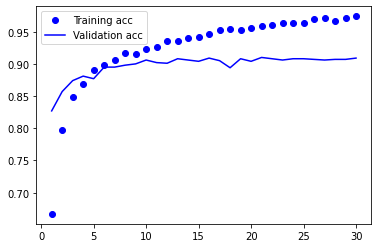

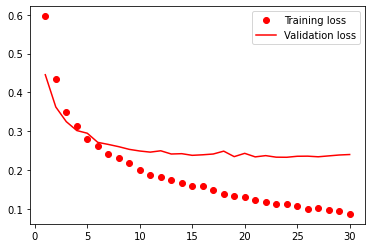

In [8]:
# Listing 5.19 Plotting the results
import matplotlib.pyplot as plt

print(history.history.keys())

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_acc = range(1, len(acc) + 1)
epochs_val = range(1, len(val_acc) + 1)

plt.plot(epochs_acc, acc, 'bo', label='Training acc')
plt.plot(epochs_val, val_acc, 'b', label='Validation acc')
plt.legend()
plt.figure()
plt.plot(epochs_acc, loss, 'ro', label='Training loss')
plt.plot(epochs_val, val_loss, 'r', label='Validation loss')
plt.legend()

plt.show()